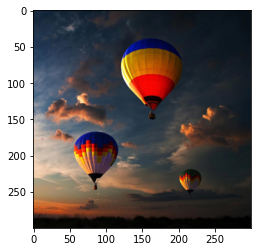

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import heapq
import random
from tqdm import tqdm


# Ouvrir l'image
file = 'montgolfiere.jpg'
img = Image.open(file)

# Convertir l'image en une matrice numpy
image = np.asarray(img)
plt.imshow(image)

In [2]:
xmin, ymin, xmax, ymax = 150, 120, 180, 150
new_img = img.crop((xmin, ymin, xmax, ymax))

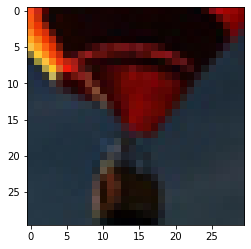

In [3]:
plt.imshow(new_img)

In [7]:
new_img.save('new_img.jpg', format='JPEG')
file = 'new_img.jpg'

In [8]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import skimage.color
from sklearn.cluster import SpectralClustering

ModuleNotFoundError: No module named 'skimage'

In [9]:
import numpy as np
from scipy import signal
import matplotlib.image as mpimg
import math

def gaussian_kernel(k, s = 0.8):
    # generate a (2k+1)x(2k+1) gaussian kernel with mean=0 and sigma = s
    probs = [math.exp(-z*z/(2*s*s))/math.sqrt(2*math.pi*s*s) for z in range(-k,k+1)]
    return np.outer(probs, probs)

rgb = mpimg.imread(file)[:,:,:3]
gauss_kernel = gaussian_kernel(k=1, s=0.8)
for i in range(3):
    rgb[:,:,i] = signal.convolve2d(rgb[:,:,i], gauss_kernel, boundary='symm', mode='same')

In [11]:
img_floue = Image.fromarray(rgb.astype(np.uint8))

# Enregistrer l'image au format JPEG
img_floue.save('img_floue.jpg', format='JPEG')
file = 'img_floue.jpg'

In [12]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

class Graph:
    def __init__(self, V):
        self.V = V 
        self.graph = []
        
    def add_edge(self, u, v, w):
        self.graph.append([u, v, w])
        
    def find_parent(self, parent, i):
        if parent[i] == i:
            return i
        return self.find_parent(parent, parent[i])
    
    def union(self, parent, rank, x, y):
        root_x = self.find_parent(parent, x)
        root_y = self.find_parent(parent, y)
        
        if rank[root_x] < rank[root_y]:
            parent[root_x] = root_y
        elif rank[root_x] > rank[root_y]:
            parent[root_y] = root_x
        else:
            parent[root_y] = root_x
            rank[root_x] += 1
    
    def chazelle_mst(self):
        # Créer une liste pour stocker les arêtes de l'arbre couvrant minimal
        mst = []
        
        # Créer un dictionnaire pour stocker le degré aléatoire de chaque sommet
        degrees = {i: random.random() for i in range(self.V)}
        
        # Trier les arêtes en ordre décroissant de leur degré aléatoire
        sorted_edges = sorted(self.graph, key=lambda edge: degrees[edge[0]], reverse=True)
        
        # Créer un tableau pour stocker les parents de chaque sommet
        parent = [i for i in range(self.V)]
        # Créer un tableau pour stocker les rangs de chaque ensemble
        rank = [0 for _ in range(self.V)]
        
        # Pour chaque arête triée,
        # fusionner les ensembles contenant les sommets de l'arête si nécessaire
        for u, v, w in sorted_edges:
            root_u = self.find_parent(parent, u)
            root_v = self.find_parent(parent, v)
            
            if root_u != root_v:
                mst.append((u, v, w))
                self.union(parent, rank, root_u, root_v)
        
        return mst

    def kruskal_mst(self):
        result = []
        i = 0 
        e = 0 #nombre d'arrêtes
        parent = []
        rank = []

        # Initialisation de parent et rank pour chaque nœud du graphe
        for node in range(self.V):
            parent.append(node)
            rank.append(0)
            
        # Tri des bords en fonction de leur poids (troisième élément)
        self.graph = sorted(self.graph, key=lambda item: item[2])
        
        # Parcours des bords triés
        while e < self.V - 1:
            # Récupération des informations sur le prochain bord
            u, v, w = self.graph[i]
            i = i + 1

            # Recherche du parent de u et de v
            x = self.find_parent(parent, u)
            y = self.find_parent(parent, v)

            # Si u et v n'ont pas le même parent, on peut ajouter l'arête au mst
            if x != y:
                e = e + 1
                result.append([u, v, w])
                # Union des deux sous-arbres enracinés à x et y
                self.union(parent, rank, x, y)

        # Calcul du coût total de l'arbre de recouvrement minimum
        mst_cost = sum([i[2] for i in result])
        # Retourne le coût et les arêtes de l'arbre de recouvrement minimum
        return mst_cost, result
    

     
def graph_from_image(image):
    img = Image.open(image).convert("RGB")
    width, height = img.size
    pixels = img.load()

    V = width * height # autant de sommets que de pixels
    graph = Graph(V)

    for i in tqdm(range(width)):
        for j in range(height):
            pixel = pixels[i, j]

            #on récupère les voisins de chaque pixels
            neighbors = []
            if i > 0:
                neighbors.append((i-1, j))
            if i < width-1:
                neighbors.append((i+1, j))
            if j > 0:
                neighbors.append((i, j-1))
            if j < height-1:
                neighbors.append((i, j+1))

            for n in neighbors:
                neighbor_pixel = pixels[n[0], n[1]] #récupère les valeurs RGB du pixel voisin
                weight = np.sqrt(sum((np.array(pixel) - np.array(neighbor_pixel))**2)) #distance euclidienne selon les valeurs RGB
                u = i * height + j #indice du pixel de base
                v = n[0] * height + n[1] #indice du pixel voisin
                graph.add_edge(u, v, weight)

    return graph

In [13]:
start_time = time.time()
graph = graph_from_image(file)
end_time = time.time()
    
elapsed_time = end_time - start_time
print("Temps écoulé pour la création du graphe : ", elapsed_time)


100%|██████████| 10/10 [00:00<00:00, 4682.71it/s]

Temps écoulé pour la création du graphe :  0.01510167121887207


In [107]:
start_time = time.time()
mst_cost, mst_edges = graph.kruskal_mst()
end_time = time.time()
    
elapsed_time = end_time - start_time
print("Temps écoulé Kruskal : ", elapsed_time)

Temps écoulé Kruskal :  0.008009672164916992


In [108]:
start_time = time.time()
mst = graph.chazelle_mst()
end_time = time.time()
elapsed_time = end_time - start_time
print("Temps écoulé Chazelle : ", elapsed_time)

Temps écoulé Chazelle :  0.0


In [109]:
img.size[0]

300

In [9]:
# Définir la liste d'arêtes contenant les sommets u et v ainsi que le poids de l'arrête les reliant
def show_graph(edge_list,img):
    
    #On arrondit pour faciliter l'affichage ! attention, il faudra modifier l'arrondi
    for i in range(len(edge_list)):
        edge_list[i][2]=round(edge_list[i][2],2)
    
    # Créer un objet graphe avec les arêtes
    G = nx.Graph()
    G.add_weighted_edges_from(edge_list)

    # Créer une disposition rectangulaire des nœuds
    pos = {}
    width = img.size[1] # largeur de l'image en pixels
    height = img.size[0] # hauteur de l'image en pixels
    i = 0
    for x in range(width):
        for y in range(height):
            pos[i] = (x, height-1-y)
            i += 1

    # Tracer le graphe avec les poids des arêtes
    nx.draw_networkx(G, pos=pos, with_labels=False, node_size=30)
    edge_labels = {(e[0], e[1]): e[2] for e in edge_list}
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, font_size=8)

    # Afficher le graphe
    plt.gca().set_aspect('equal', adjustable='box')
    fig = plt.gcf()
    fig.set_size_inches(20*width, 20*height)

    # Enregistrement de l'image dans l'objet graph_plot
    # graph_plot = plt.gcf()
    #plt.savefig('graphe2.jpg')
    plt.show()
    

In [11]:
print("Graphe pour l'image initiale:")
show_graph(graph.graph, img)

Graphe pour l'image initiale:


ValueError: Image size of 432000x432000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432000x432000 with 1 Axes>

In [12]:
print("Arbre couvrant de poids minimal de ce graphe")
show_graph(mst_edges)

Arbre couvrant de poids minimal de ce graphe


NameError: name 'mst_edges' is not defined

In [ ]:
#print("Arbre couvrant de poids minimal de ce graphe")
#show_graph(mst)
#IL FAUT TRANSFORMER LES TUPLES dans mst EN LISTES!!

# SEGMENTATION

In [14]:
def segmentation_algorithm(V, E):
    # 0. Sort E into π = (o1, . . . , om), by non-decreasing edge weight.
    E.sort(key=lambda e: e[2])
    
    # 1. Start with a segmentation S0, where each vertex vi is in its own component
    S = [[v] for v in V]
    
    # 2. Repeat step 3 for q = 1, . . . , m
    
    for q in tqdm(range(len(E))): 
        (vi, vj, w) = E[q]
        Ci = Cj = None
        for i in range(len(S)):
            if vi in S[i]:
                Ci = i
            if vj in S[i]:
                Cj = i
            if Ci is not None and Cj is not None:
                break
        if Ci != Cj and w <= internal_difference(S[Ci], S[Cj]):
            S[Ci] += S[Cj]
            del S[Cj]
    
    return S

def internal_difference(Ci, Cj):
    diff_sum = 0
    for vi in Ci:
        for vj in Cj:
            diff_sum += abs(vi - vj)
    return diff_sum / (len(Ci) * len(Cj))


In [15]:
import random

def generate_colors(n):
    colors = []
    for i in range(n):
        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)
        color = (red, green, blue)

        colors.append(color)
    return colors

n = 5
colors = generate_colors(n)
print(colors)

[(248, 155, 162), (28, 95, 180), (110, 226, 76), (81, 82, 101), (124, 1, 126)]


In [16]:
def segmented_image(img,E):
    
    width = img.size[1]
    height = img.size[0]
    
    V = np.arange(width*height) 
    
    S = segmentation_algorithm(V,E)
    
    segmented_img = np.zeros((width, height, 3), dtype=np.uint8)

    colors = generate_colors(len(S))
    for i in range(len(S)):
        color = colors[i]
        for v in S[i]:
            segmented_img[v%width,v//height] = color
    
    plt.imshow(segmented_img)
    plt.show()
                         
    return segmented_img, S

Image initiale:


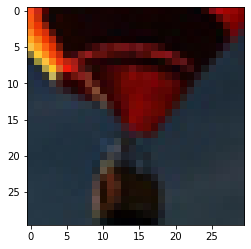

Image segmentée:


100%|██████████| 360/360 [00:00<00:00, 72067.08it/s]


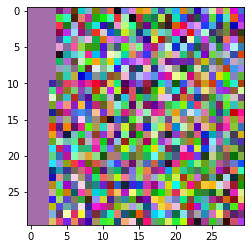

Temps écoulé Segmentation :  0.08500957489013672


In [18]:
E = graph.graph
print("Image initiale:")
plt.imshow(new_img)
plt.show()
print("Image segmentée:")
start_time = time.time()
seg,S = segmented_image(new_img,E)
end_time = time.time()
elapsed_time = end_time - start_time
print("Temps écoulé Segmentation : ", elapsed_time)


# Numba

In [30]:
import numba as nb
from tqdm import tqdm

@nb.njit
def segmentation_algorithm_numba(V, E):
    E.sort(key=lambda e: e[2])
    
    S = [[v] for v in V]
    
    for q in tqdm(range(len(E))):
        (vi, vj, w) = E[q]
        Ci = Cj = None
        for i in range(len(S)):
            if vi in S[i]:
                Ci = i
            if vj in S[i]:
                Cj = i
            if Ci is not None and Cj is not None:
                break
        if Ci != Cj and w <= internal_difference(S[Ci], S[Cj]):
            S[Ci] += S[Cj]
            del S[Cj]
    
    return S

@nb.njit
def internal_difference(Ci, Cj):
    diff_sum = 0
    for vi in Ci:
        for vj in Cj:
            diff_sum += abs(vi - vj)
    return diff_sum / (len(Ci) * len(Cj))


Image initiale:


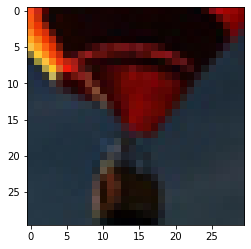

Image segmentée:


  0%|          | 0/360 [00:00<?, ?it/s]C:\Users\trist\anaconda3\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'Ci' of function 'internal_difference'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\AppData\Local\Temp\ipykernel_30228\3697200504.py", line 26:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\trist\anaconda3\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'Cj' of function 'internal_difference'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

Fil

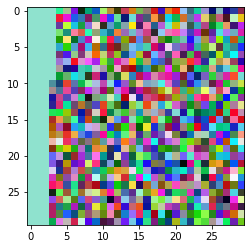

Temps écoulé Segmentation :  0.516812801361084


In [31]:
E = graph.graph
print("Image initiale:")
plt.imshow(new_img)
plt.show()
print("Image segmentée:")
start_time = time.time()
seg,S = segmented_image(new_img,E)
end_time = time.time()
elapsed_time = end_time - start_time
print("Temps écoulé Segmentation : ", elapsed_time)

# Cython

In [47]:
import numpy as np

In [ ]:
%load_ext Cython

In [50]:
%load_ext Cython
import numpy as np

%%cython

from tqdm import tqdm
import numpy as np


def segmentation_algorithm_c(V, E): 
    cdef int[:, :] E_sorted = np.ascontiguousarray(E[:, :3].view('i,i,i'))
    E_sorted.sort(order=['f2'], axis=0)
    
    cdef list S = [[v] for v in V]
    
    cdef int q, vi, vj, w, Ci, Cj
    cdef int i, j, n, m
    
    n = len(S)
    m = E.shape[0]
    
    for q in tqdm(range(m)):
        vi, vj, w = E_sorted[q]
        Ci = Cj = -1
        
        for i in range(n):
            if vi in S[i]:
                Ci = i
            if vj in S[i]:
                Cj = i
            if Ci != -1 and Cj != -1:
                break
        
        if Ci != Cj and w <= internal_difference(S[Ci], S[Cj]):
            S[Ci] += S[Cj]
            del S[Cj]
    
    return S

def internal_difference(Ci, Cj):
    cdef int diff_sum = 0
    cdef int vi, vj
    cdef int len_Ci = Ci.shape[0]
    cdef int len_Cj = Cj.shape[0]
    
    for vi in Ci:
        for vj in Cj:
            diff_sum += abs(vi - vj)
    
    return diff_sum / (len_Ci * len_Cj)


SyntaxError: invalid syntax (72185794.py, line 11)

In [53]:
%load_ext Cython
import numpy as np

%%cython

from tqdm import tqdm
import numpy as np


def segmentation_algorithm_c(V, E): 
    E_sorted = np.ascontiguousarray(E[:, :3].view('i,i,i'))
    E_sorted.sort(order=['f2'], axis=0)
    
    S = [[v] for v in V]
    
    q, vi, vj, w, Ci, Cj
    i, j, n, m
    
    n = len(S)
    m = E.shape[0]
    
    for q in tqdm(range(m)):
        vi, vj, w = E_sorted[q]
        Ci = Cj = -1
        
        for i in range(n):
            if vi in S[i]:
                Ci = i
            if vj in S[i]:
                Cj = i
            if Ci != -1 and Cj != -1:
                break
        
        if Ci != Cj and w <= internal_difference(S[Ci], S[Cj]):
            S[Ci] += S[Cj]
            del S[Cj]
    
    return S

def internal_difference(Ci, Cj):
    diff_sum = 0
    vi, vj
    len_Ci = Ci.shape[0]
    len_Cj = Cj.shape[0]
    
    for vi in Ci:
        for vj in Cj:
            diff_sum += abs(vi - vj)
    
    return diff_sum / (len_Ci * len_Cj)


The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


UsageError: Line magic function `%%cython` not found.


In [117]:
import numpy as np
from PIL import Image

# Charger l'image en tant qu'objet Image
img = Image.open("IMAGE.jpg")

# Convertir l'objet Image en tableau Numpy
img_arr = np.array(img)

# Dupliquer l'image 2 fois dans chaque direction
img_arr = np.tile(img_arr, (3, 3, 1))

# Convertir le tableau Numpy en objet Image
img_dup = Image.fromarray(img_arr)

# Afficher l'image dupliquée
img_dup.show()

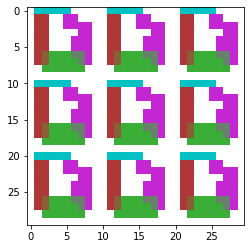

In [140]:
image = np.asarray(img_dup)
plt.imshow(image)

In [ ]:

width = img.size[1]
height = img.size[0]
    
V = np.arange(width*height) 
    
S = segmentation_algorithm(V,E)

 23%|██▎       | 81732/358800 [20:18<1:28:47, 52.01it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_3012\492821130.py:30: RuntimeWarning: overflow encountered in long_scalars
  diff_sum += abs(vi - vj)
 92%|█████████▏| 329623/358800 [3:40:01<8:24:21,  1.04s/it]  

In [ ]:
#penser à voir à quoi ressemble le graphe